# Classificação Supervisionada

## Preparando ambiente

In [1]:
install.packages('raster')
require(raster)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘sp’, ‘terra’


Loading required package: raster

Loading required package: sp



In [2]:
install.packages('rgdal')
require(rgdal)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: rgdal

Please note that rgdal will be retired by the end of 2023,
plan transition to sf/stars/terra functions using GDAL and PROJ
at your earliest convenience.

rgdal: version: 1.5-27, (SVN revision 1148)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 2.2.3, released 2017/11/20
Path to GDAL shared files: /usr/share/gdal/2.2
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
Path to PROJ shared files: (autodetected)
Linking to sp version:1.4-5



In [ ]:
install.packages('ggplot2')
require(ggplot2)

In [4]:
install.packages('dplyr')
require(dplyr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:raster’:

    intersect, select, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Pontos de referência para treinamento

In [5]:
pontosTreinamento = shapefile('cipef_poi.shp')
head(pontosTreinamento@data)

,id,class
,<chr>,<int>
1,NA,1
2,NA,1
3,NA,1
4,NA,1
5,NA,1
6,NA,1


In [6]:
aoi = brick('cipef_50cm_v2.tif')
names(aoi) = c("red", "green", 'blue', 'alpha')
aoi = aoi[[-4]]

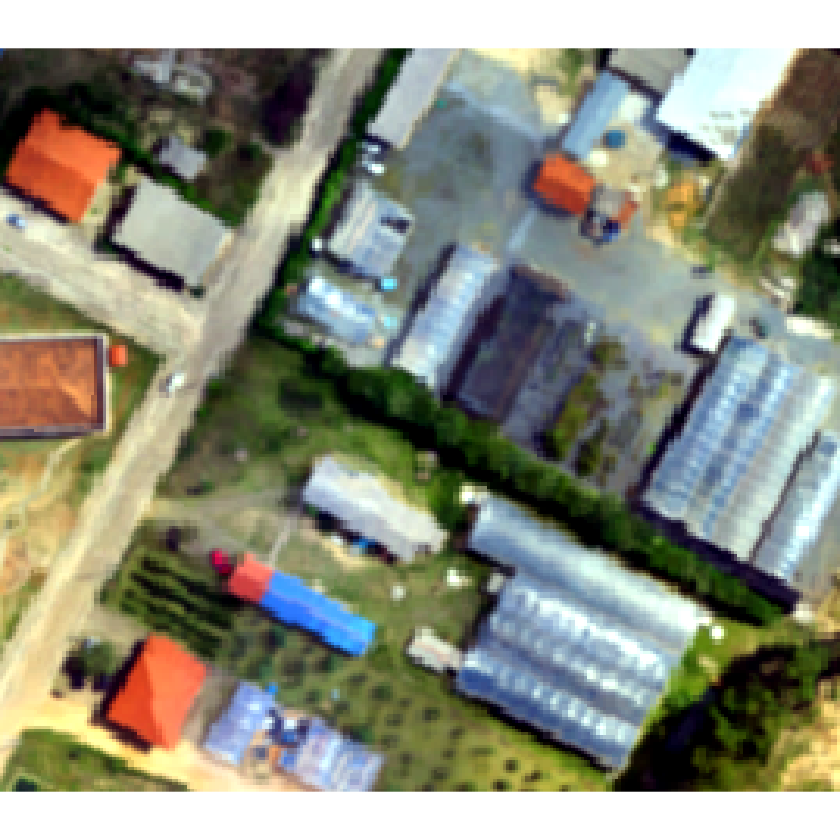

In [7]:
plotRGB(aoi, r = 1, g = 2, b = 3, stretch = 'lin')

In [8]:
sampvals = extract(aoi, pontosTreinamento, df = TRUE)
sampvals = sampvals[, -1]
sampdata = data.frame(classvalue = pontosTreinamento@data$class, sampvals)
head(sampdata)

,classvalue,red,green,blue
,<int>,<dbl>,<dbl>,<dbl>
1,1,91,88,66
2,1,87,96,53
3,1,76,77,51
4,1,72,89,48
5,1,50,65,32
6,1,60,74,33


In [9]:
mediaGrupo = sampdata %>%
  group_by(classvalue) %>%
  summarise(red = mean(red),
            green = mean(green),
            blue = mean(blue))

mediaGrupo

classvalue,red,green,blue
<int>,<dbl>,<dbl>,<dbl>
1,70.30769,76.84615,40.23077
2,151.36364,136.03030,134.06061


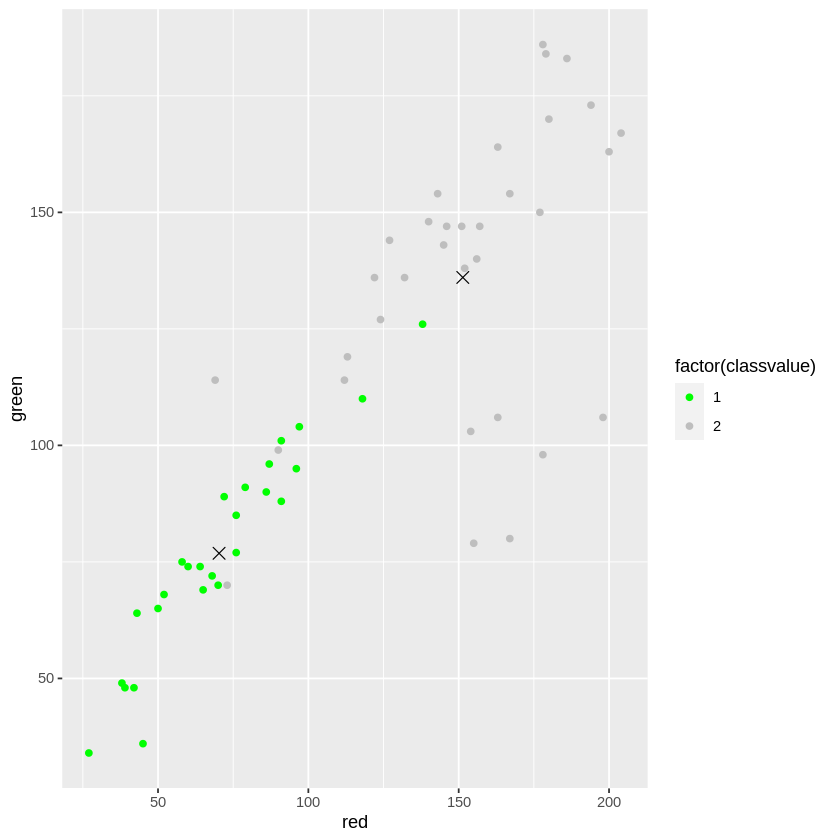

In [10]:
ggplot(sampdata, aes(x = red, y = green)) + 
  geom_point(aes(colour = factor(classvalue))) + 
  geom_point(data = mediaGrupo, aes(red, green), shape = 4, size = 3) +
  scale_color_manual(values = c("1" = "green", "2" = "gray"))

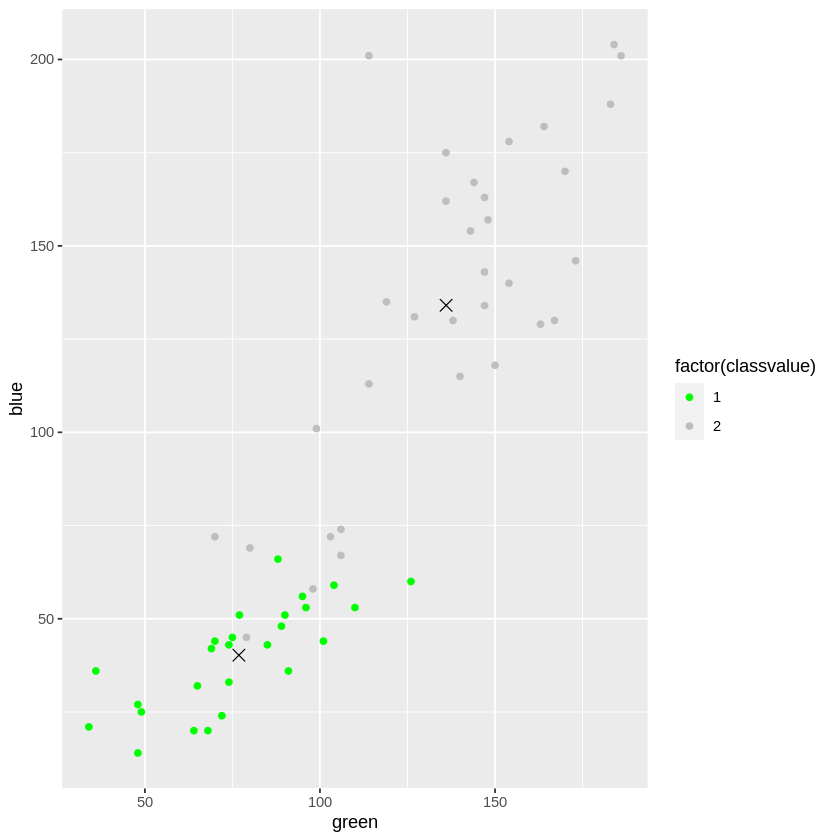

In [ ]:
ggplot(sampdata, aes(x = green, y = blue)) + 
  geom_point(aes(colour = factor(classvalue))) + 
  geom_point(data = mediaGrupo, aes(green, blue), shape = 4, size = 3) +
  scale_color_manual(values = c("1" = "green", "2" = "gray"))

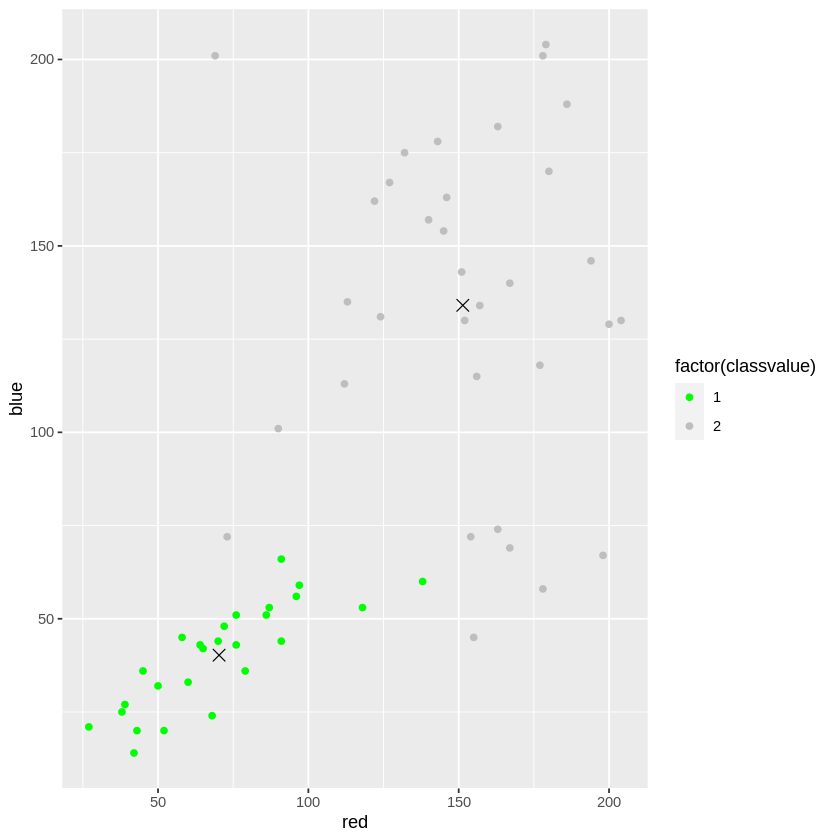

In [ ]:
ggplot(sampdata, aes(x = red, y = blue)) + 
  geom_point(aes(colour = factor(classvalue))) + 
  geom_point(data = mediaGrupo, aes(red, blue), shape = 4, size = 3) +
  scale_color_manual(values = c("1" = "green", "2" = "gray"))

# Distância mínima



$$d_{euc}(x,y) = \sqrt{\sum^n_{i=1}(x_i - y_i)^2}$$

# Classificação

## Exemplo para o primeiro pixel


In [11]:
blue = getValues(aoi[[1]])
green = getValues(aoi[[2]])
red = getValues(aoi[[3]])
nr = cbind(red, green, blue)

In [12]:
mediaGrupo

classvalue,red,green,blue
<int>,<dbl>,<dbl>,<dbl>
1,70.30769,76.84615,40.23077
2,151.36364,136.03030,134.06061


In [13]:
euclidean = function(a, b){sqrt(sum((a - b)^2))}

In [14]:
euclidean(nr[1,], mediaGrupo[1,2:4])

[1] 39.38882

In [15]:
euclidean(nr[1,], mediaGrupo[2,2:4])

[1] 112.926

## Classificação da área de interesse

In [16]:
distClass1 = data.frame(distClass1 = apply(nr, 1, function(x) sqrt(sum((x - mediaGrupo[1,2:4])^2))))

In [17]:
distClass2 = data.frame(distClass2 = apply(nr, 1, function(x) sqrt(sum((x - mediaGrupo[2,2:4])^2))))

In [18]:
nr = cbind(nr, distClass1, distClass2)
head(nr)

,red,green,blue,distClass1,distClass2
,<int>,<int>,<int>,<dbl>,<dbl>
1,108,73,51,39.38882,112.9260
2,75,73,67,27.44818,119.5882
3,56,68,71,35.06722,133.0375
4,52,69,71,36.65350,135.4357
5,52,69,71,36.65350,135.4357
6,54,70,72,36.36062,133.0083


In [19]:
nr$class = ifelse(nr$distClass1 < nr$distClass2, 1, 2)
head(nr)

,red,green,blue,distClass1,distClass2,class
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,108,73,51,39.38882,112.9260,1
2,75,73,67,27.44818,119.5882,1
3,56,68,71,35.06722,133.0375,1
4,52,69,71,36.65350,135.4357,1
5,52,69,71,36.65350,135.4357,1
6,54,70,72,36.36062,133.0083,1


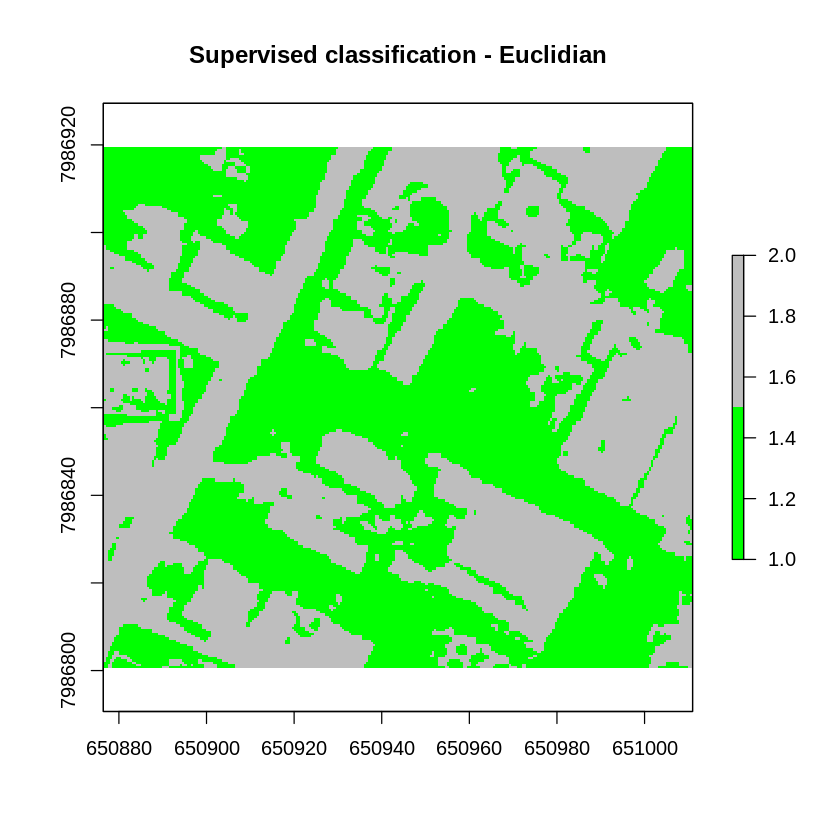

In [20]:
mycolor = c("green","gray")
classified = setValues(aoi[[1]], nr$class)
plot(classified, main = 'Supervised classification - Euclidian', col=mycolor)

In [21]:
writeRaster(classified, 'classifedEuclidian.tif')